In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
from abn.models.spherical_vae import SphericalVAE
from abn.trainer.svae_trainer import SphericalVAETrainer
from abn.datasets.cyclic_walk import CyclicWalk
from abn.new_vae.datasets.wiggles import Wiggles
from abn.datasets.data_loader import TrainValLoader

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend


# Hyperspherical VAE

## Load Dataset

40it [00:41,  1.03s/it]
/Users/sophia/projects/abn/abn/notebooks/../../abn/datasets/cyclic_walk.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(angles, dtype=torch.float32)


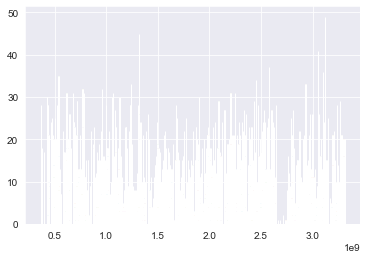

In [19]:
path = "../data/expt34.mat" # CHANGE TO YOUR DATA LOCATION IF NEEDED
time_bin = 1000000
dataset = CyclicWalk(path=path, time_bin=time_bin, velocity_threshold=0.3)

In [10]:
# torch.save(dataset, "../data/expt34_processed.pt")

In [23]:
dataset = torch.load("../data/expt34_processed.pt")

In [4]:
dataset = Wiggles(n_times=1000,n_wiggles=5, synth_radius=1,amp_wiggles=0.3,embedding_dim=2,rotation=True,noise_var=0.001)

## Normalize the Data

Note: Different normalization schemes have a *HUGE* impact on the training procedure.
Options that should be explored include:
- Z-scoring each neuron's response across the entire dataset
- Setting min of the entire dataset to 0 and max to 1
- Setting the norm of each neural state vector to 1

They are each implemented below. Uncomment options to try them out

In [66]:
"""
Z-Scoring
"""
# dataset.data = dataset.data - dataset.data.mean(axis=-1, keepdim=True)
# dataset.data = dataset.data / dataset.data.std(axis=-1, keepdim=True)
# print(dataset.data.std(axis=-1))

'\nZ-Scoring\n'

In [5]:
"""
Min 0 Max 1
"""
dataset.data = dataset.data - dataset.data.min()
dataset.data = dataset.data / dataset.data.max()

In [21]:
"""
Unit Norm
"""
# dataset.data = dataset.data / torch.linalg.norm(dataset.data, dim=-1, keepdim=True)
# print(torch.linalg.norm(dataset.data, dim=-1))

'\nUnit Norm\n'

## Train Val Split and Generate Batches

In [6]:
data_loader = TrainValLoader(batch_size=20)
data_loader.load(dataset)

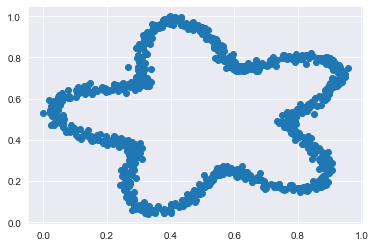

In [7]:
x=dataset.data[:,0]
y = dataset.data[:,1]
plt.scatter(x,y)

## Construct Model

In [8]:
model = SphericalVAE(input_dim=2,
                     encoder_dims=[40,40,40,40,40],
                     latent_dim=2,
                     distribution="vmf")

optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SphericalVAETrainer(model=model, optimizer=optimizer)

## Train Model

In [9]:
trainer.train(data_loader, 100)

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0 ||  N Examples 0 || Train Total Loss 1.42181 || Validation Total Loss 1.38111
Epoch 1 ||  N Examples 800 || Train Total Loss 1.37088 || Validation Total Loss 1.35002
Epoch 2 ||  N Examples 1600 || Train Total Loss 1.37372 || Validation Total Loss 1.37936
Epoch 3 ||  N Examples 2400 || Train Total Loss 1.36623 || Validation Total Loss 1.37708
Epoch 4 ||  N Examples 3200 || Train Total Loss 1.36508 || Validation Total Loss 1.36016
Epoch 5 ||  N Examples 4000 || Train Total Loss 1.36899 || Validation Total Loss 1.34573
Epoch 6 ||  N Examples 4800 || Train Total Loss 1.35985 || Validation Total Loss 1.36189
Epoch 7 ||  N Examples 5600 || Train Total Loss 1.35405 || Validation Total Loss 1.36170
Epoch 8 ||  N Examples 6400 || Train Total Loss 1.35253 || Validation Total Loss 1.33177
Epoch 9 ||  N Examples 7200 || Train Total Loss 1.34408 || Validation Total Loss 1.34604
Epoch 10 ||  N Examples 8000 || Train Total Loss 1.35204 || Validation Total Loss 1.33518
Epoch 11 ||  N Examples 

## Visualize Latent Space

In [71]:
with torch.no_grad():
    (z_mean, z_var), (q_z, p_z), z = model.to_latent(dataset.data)

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [66]:
df = pd.DataFrame({"z0": z[:, 0], 
                    "z1": z[:, 1], 
                    "pos": dataset.labels % (2 * np.pi)})
#                     "pos": (dataset.pos + dataset.angle) % (2 * np.pi)})

<AxesSubplot:xlabel='z0', ylabel='z1'>

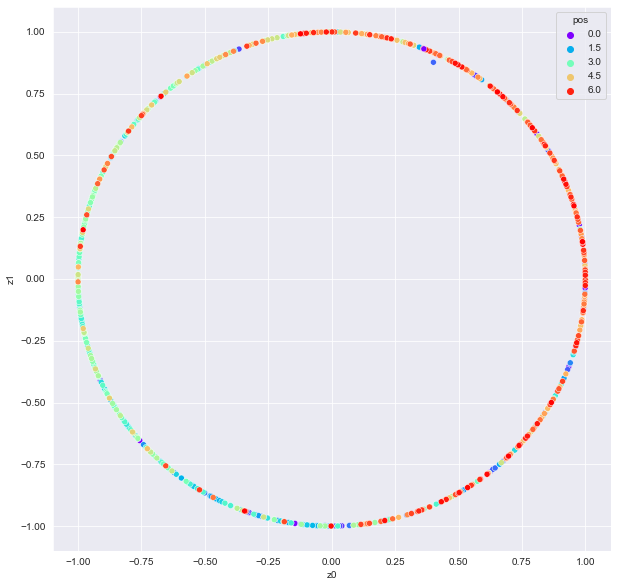

In [67]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")

In [52]:
def get_immersion(model):

    def immersion(angle):
        z = torch.tensor([torch.cos(angle), torch.sin(angle)], requires_grad=True)
        x_rec = model.decode(z)
        return x_rec

    return immersion

In [31]:
def plot_model(thetas, model):
    immersion = get_immersion(model)
    rec = [immersion(theta) for theta in thetas]
    x = [vec[0].detach().numpy() for vec in rec]
    y = [vec[1].detach().numpy() for vec in rec]
    plt.scatter(x,y,c=thetas)

In [32]:
angles = torch.linspace(0,2*torch.pi,1000)

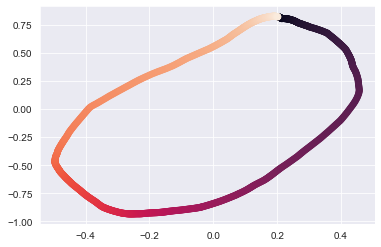

In [33]:
plot_model(angles, model)

In [76]:
z[0][0]

tensor(0.9802)

In [74]:
theta = torch.tensor(torch.pi/3, requires_grad=True)

def func(x):
    return imm(x)[0]

z = torch.tensor([torch.cos(theta), torch.sin(theta)])  

z = q_z.rsample()


def func(z):
    return model.decode(z[0])[0]

g = torch.autograd.grad(model.decode(z)[0], inputs=z[0])
print(g)

H = torch.autograd.functional.hessian(func, inputs=theta, strict=True)

torch.Size([1000, 2])

In [94]:
def func(z):
    return model.decode(z)[0]

z0 = z[40]
func(z0)
H = torch.autograd.functional.jacobian(func, inputs=z0, strict=True)
g = torch.autograd.grad(func(z0), z0)

RuntimeError: One of the differentiated Tensors does not require grad

In [101]:
J = torch.autograd.functional.jacobian(model.decode, inputs = z0, strict=True)

In [103]:
def func(z):

    return model.decode(z)[0]

False

In [34]:
model.mu.weight.grad

tensor([[-1.7735e-02, -1.1684e-02, -5.9883e-03,  0.0000e+00,  0.0000e+00,
         -1.0751e-02,  0.0000e+00,  0.0000e+00, -1.0058e-02,  0.0000e+00,
         -3.5588e-02, -1.8118e-02, -2.9693e-03, -2.0818e-02, -6.1335e-04,
          0.0000e+00,  2.9269e-04, -5.5316e-03, -1.4035e-02, -1.7198e-02,
         -2.1172e-03, -1.9190e-02, -5.8859e-03, -2.1042e-03, -5.1348e-04,
         -1.3232e-02, -5.6513e-03, -1.7613e-02,  2.6353e-04, -1.7920e-03,
         -4.5642e-06, -1.0914e-02, -1.5709e-02, -5.0534e-04,  0.0000e+00,
          0.0000e+00, -1.2113e-02, -9.9021e-06,  1.3610e-04,  0.0000e+00],
        [-2.3334e-03, -5.4143e-03,  2.1532e-05,  0.0000e+00,  0.0000e+00,
          1.5034e-03,  0.0000e+00,  0.0000e+00,  3.7330e-03,  0.0000e+00,
         -2.4006e-02, -3.4166e-03, -1.2741e-04,  1.4079e-03, -3.3328e-04,
          0.0000e+00, -1.5237e-03, -4.6258e-03, -1.4839e-03, -2.0531e-02,
          8.6496e-04,  7.7104e-03, -6.2519e-04, -6.0995e-05, -1.3899e-03,
          2.7487e-03,  1.6146e-03,  7

In [35]:
def mean_curv(base_point, immersion, embedding_dim):
    H = torch.zeros(embedding_dim)
    for i in range(embedding_dim):
        H[i] = torch.autograd.functional.hessian(
            func=lambda x: immersion(x)[i], inputs=base_point
        )
    return H

In [45]:
imm(theta)[0]

tensor(0.4116, grad_fn=<SelectBackward0>)

In [54]:
imm = get_immersion(model)

In [37]:
imm(theta)[0]
func(theta)

tensor(0.4116)

In [64]:
theta = torch.tensor(torch.pi/3, requires_grad=True)

def func(x):
    return imm(x)[0]

z = torch.tensor([torch.cos(theta), torch.sin(theta)])  

z = q_z.rsample()

#g = torch.autograd.grad(model.decode(z)[0], inputs=z[0])
#print(g)

H = torch.autograd.functional.hessian(func, inputs=theta, strict=True)

RuntimeError: grad can be implicitly created only for scalar outputs

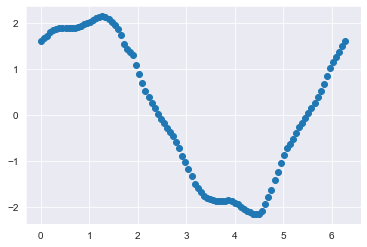

In [ ]:
x = torch.linspace(0,2*torch.pi,100)
y = [func(th).cpu().detach().numpy() for th in x]

x = x.cpu().detach().numpy()
y = y

plt.scatter(x,y)

In [257]:
func = lambda x: imm(x)[0]

g = torch.autograd.functional.hessian(func,inputs=theta, strict=True)

RuntimeError: While computing the hessian, found that the jacobian of the user-provided function with respect to input 0 is independent of the input. This is not allowed in strict mode. You should ensure that your function is twice differentiable and that the jacobian depends on the inputs (this would be violated by a linear function for example).

In [261]:
torch.save(model.state_dict(),"../results/modelsd.pt")

In [172]:
def get_curv_profile(angles,model,embedding_dim):
    immersion = get_immersion(model)
    mean_curv_vecs = [mean_curv(angle,immersion,embedding_dim) for angle in angles]
    norms = [torch.linalg.norm(vec) for vec in mean_curv_vecs]
    return norms

In [197]:
angles = torch.linspace(0,2*torch.pi,1000)

norms = get_curv_profile(angles,model,2)

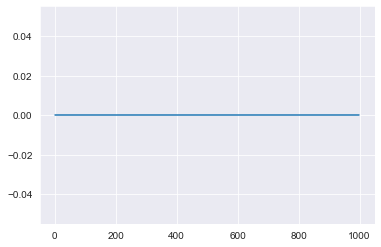

In [198]:
plt.plot(norms)

In [199]:
x_ = model(dataset.data)[-1]

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


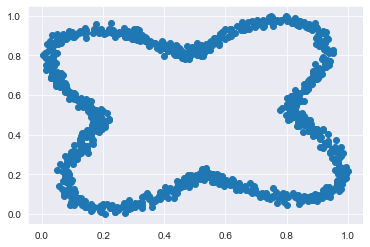

In [227]:
a = dataset.data[:,0]
b = dataset.data[:,1]

plt.scatter(a,b)

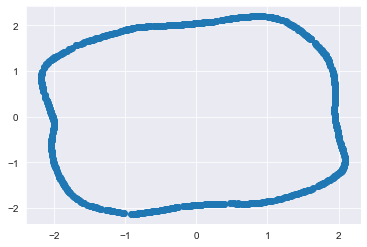

In [228]:
a_ = x_[:,0].cpu().detach().numpy()
b_ = x_[:,1].cpu().detach().numpy()

plt.scatter(a_,b_)

In [48]:
z_mean, z_var = model.encode(dataset.data)

In [49]:
q_z, p_z = model.reparameterize(z_mean, z_var)

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [51]:
q_z.rsample().requires_grad

True

In [109]:
z.shape

torch.Size([1000, 2])

In [133]:
def func(z):
    x_rec0 = model.decode(z)[0]
    return x_rec0

In [123]:
xrec0 = func(z)

In [131]:
z0 =z[0]

In [134]:
H0 = torch.autograd.functional.hessian(func=func, inputs = z0, strict=True)

In [138]:
func(z0)

tensor(0.2198, grad_fn=<SelectBackward0>)

In [136]:
J = torch.autograd.functional.jacobian(func=func, inputs=z0, strict=True)

In [137]:
J

tensor([0.1168, 0.1596])